In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu115
0.12.0+cu115


In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [4]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.fc1(t.reshape(-1, 12 * 4 * 4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t

In [6]:
network = Network()

In [7]:
data_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = 100
)
batch = next(iter(data_loader))
images, labels = batch

In [8]:
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item()

2.3157265186309814

In [9]:
print(network.conv1.weight.grad)

None


In [10]:
loss.backward()

In [11]:
network.conv1.weight.grad.shape

torch.Size([6, 1, 5, 5])

In [12]:
optimizer = optim.Adam(network.parameters(), lr=0.01)

In [13]:
loss.item()

2.3157265186309814

In [14]:
get_num_correct(preds, labels)

9

In [15]:
optimizer.step()

In [16]:
preds = network(images)
loss = F.cross_entropy(preds, labels)

In [17]:
loss.item()

2.298996925354004

In [18]:
get_num_correct(preds, labels)

10

#### **单次训练步骤集合**

In [19]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.SGD(network.parameters(), lr=0.01)

batch = next(iter(train_loader))
images, labels = batch

preds = network(images)
loss = F.cross_entropy(preds, labels)

loss.backward()
optimizer.step()

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.302199125289917
loss2: 2.302027940750122


In [20]:
print(type(loss))

<class 'torch.Tensor'>


**建立循环**

In [27]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.SGD(network.parameters(), lr=0.01)

In [47]:
for epoch in range(20):

    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print("epoch:", epoch + 1, "total_correct:", total_correct, "loss:", total_loss, "Accuracy:", total_correct / len(train_set))


epoch: 1 total_correct: 9978 loss: 1359.5729160308838 Accuracy: 0.1663
epoch: 2 total_correct: 35200 loss: 695.3083716034889 Accuracy: 0.5866666666666667
epoch: 3 total_correct: 41328 loss: 484.3503445982933 Accuracy: 0.6888
epoch: 4 total_correct: 43409 loss: 429.5483495295048 Accuracy: 0.7234833333333334
epoch: 5 total_correct: 44839 loss: 395.150179207325 Accuracy: 0.7473166666666666
epoch: 6 total_correct: 45879 loss: 368.5928876698017 Accuracy: 0.76465
epoch: 7 total_correct: 46921 loss: 347.06320506334305 Accuracy: 0.7820166666666667
epoch: 8 total_correct: 47693 loss: 329.80504551529884 Accuracy: 0.7948833333333334
epoch: 9 total_correct: 48341 loss: 315.91582065820694 Accuracy: 0.8056833333333333
epoch: 10 total_correct: 48898 loss: 304.1372713148594 Accuracy: 0.8149666666666666
epoch: 11 total_correct: 49268 loss: 294.1128773391247 Accuracy: 0.8211333333333334
epoch: 12 total_correct: 49576 loss: 285.11552581191063 Accuracy: 0.8262666666666667
epoch: 13 total_correct: 49841 lo

In [48]:
total_correct / len(train_set)

0.8552333333333333

### **28 Analyzing CNN Result - Building and Plotting a Confusion Matrix**

In [49]:
len(train_set)

60000

In [50]:
len(train_set.targets)

60000

#### **Getting predictions for the entire training set**

In [51]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds,preds),
            dim=0
        )
    return all_preds

In [52]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [53]:
train_preds.shape

torch.Size([60000, 10])

In [54]:
print(train_preds.requires_grad)

True


In [55]:
train_preds.grad

d:\AConda\lib\site-packages\torch\_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:475.)
  return self._grad


In [56]:
train_preds.grad_fn

In [57]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

In [59]:
print(train_preds.requires_grad)

False


In [58]:
train_preds.grad

In [61]:
train_preds.grad_fn

In [62]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 51555
accuracy: 0.85925


#### **Building a confusion matrix**

In [63]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [65]:
train_set.targets.shape

torch.Size([60000])

In [64]:
train_preds.argmax(dim=1)

tensor([9, 0, 3,  ..., 3, 0, 5])

In [66]:
stacked = torch.stack(
    (
        train_set.targets,
        train_preds.argmax(dim=1)
    ),
    dim=1
)

In [67]:
stacked.shape

torch.Size([60000, 2])

In [68]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 3],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [71]:
stacked[0].tolist()

[9, 9]

In [72]:
cmt = torch.zeros(10, 10, dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [74]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [75]:
cmt

tensor([[5164,    4,  130,  259,   35,    3,  322,    0,   83,    0],
        [  14, 5722,   21,  206,   19,    2,   12,    0,    4,    0],
        [  54,    3, 4660,   64,  777,    3,  350,    1,   88,    0],
        [ 205,   22,   69, 5420,  174,    1,   93,    0,   15,    1],
        [  15,    7,  603,  245, 4735,    1,  334,    0,   60,    0],
        [   0,    0,    1,    4,    0, 5535,    1,  298,   36,  125],
        [1176,    5,  888,  203,  530,    0, 3094,    0,  104,    0],
        [   0,    0,    0,    0,    0,  104,    0, 5678,    9,  209],
        [  28,    0,   60,   33,   19,   10,   36,   13, 5799,    2],
        [   0,    0,    1,    2,    0,   40,    1,  201,    7, 5748]], dtype=torch.int32)

#### **Plotting a confusion matrix**

In [79]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [82]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5164,    4,  130,  259,   35,    3,  322,    0,   83,    0],
       [  14, 5722,   21,  206,   19,    2,   12,    0,    4,    0],
       [  54,    3, 4660,   64,  777,    3,  350,    1,   88,    0],
       [ 205,   22,   69, 5420,  174,    1,   93,    0,   15,    1],
       [  15,    7,  603,  245, 4735,    1,  334,    0,   60,    0],
       [   0,    0,    1,    4,    0, 5535,    1,  298,   36,  125],
       [1176,    5,  888,  203,  530,    0, 3094,    0,  104,    0],
       [   0,    0,    0,    0,    0,  104,    0, 5678,    9,  209],
       [  28,    0,   60,   33,   19,   10,   36,   13, 5799,    2],
       [   0,    0,    1,    2,    0,   40,    1,  201,    7, 5748]],
      dtype=int64)

In [87]:
names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

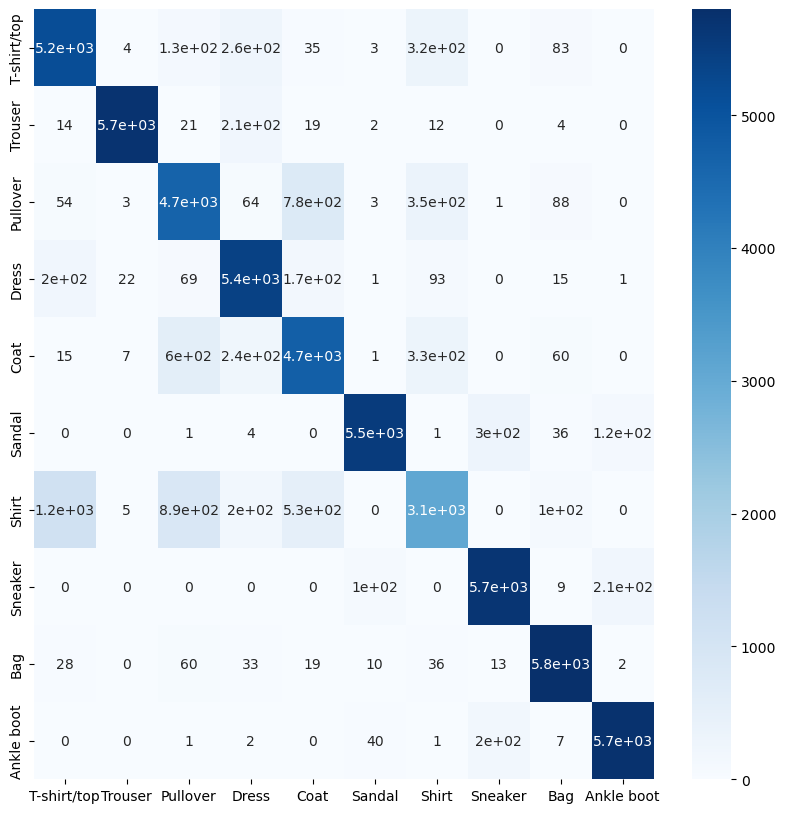

In [92]:
import seaborn as sns
import pandas as pd

# 创建一个包含数据的DataFrame
cm = cm.astype(int)
data = pd.DataFrame(data=cm, columns=names, index=names)

plt.figure(figsize=(10, 10))

# 使用Seaborn绘制热力图
sns.heatmap(data, annot=True, cmap='Blues')

# 显示图像
plt.show()
